# Assignment 4
## Clustering languages
The assignment and data are available here: https://snlp2018.github.io/assignments.html

The main dataset for the assignment is in the file `northeuralex-words.gz`. It contains IPA phonetic representation of more than 1000 words in more than 100 languages of Northern Eurasia; the dataset consists of two tab-separated columns: 3-letter ISO language code and tokenize IPA representation of a word.

### Exercise 1
Read the data and extract the features. In particular, each language in the dataset will be represented as a vector of integers, one for each IPA token in the dataset. Each integer should correspond to the count of the IPA token in the words of that language.

In [64]:
import pandas as pd
import progressbar

In [2]:
# read data
df_raw = pd.read_csv("data/northeuralex-words", sep = "\t", names = ["lang", "ipa"])
print(df_raw.head()) # let's take a look at df
print(df_raw.groupby("lang").nunique())

  lang          ipa
0  fin    s i l m æ
1  fin    k ɔ r ʋ ɑ
2  fin      n ɛ n æ
3  fin        s u u
4  fin  h ɑ m m ɑ s
      lang   ipa
lang            
ava      1   954
azj      1  1017
bak      1   962
bel      1  1042
ben      1   930
...    ...   ...
udm      1   973
ukr      1  1044
uzn      1   960
vep      1  1004
yrk      1  1014

[80 rows x 2 columns]


Next, we want to wrangle the df in such a way that we have one language per row and a list of all the IPA tokens appearing in the words of that language as value:

In [3]:
df_by_lang = df_raw.groupby("lang")["ipa"].apply(lambda x: ' '.join(x)) # group by language code and join all rows

In [4]:
print(df_by_lang.head(10))
print(df_by_lang.shape)

lang
ava    ʕ i n m j e ʕ j e r kʼ a l ʕ u s m a t͡s ʼ kʼ ...
azj    ɟ œ z ɡ u l ɑ ɡ b u r u n ɑ ɣ ɯ z d ɪ ʃ d ɪ l ...
bak    k y ð q o l a q t a n a u a u ɯ ð t e ʃ t e l ...
bel    v ɔ k a v u x a n ɔ s r ɔ t z u b j a z ɨ k ɣ ...
ben    t͡ʃ ɔ k kʰ u k ɔ r n o n a k m u kʰ d ã t ɔ d...
bre    l ɑ ɑ ɡ a t s k u u a ʀ n f ʀ i i ɡ ẽ ẽ n u ...
bul    ɔ k ɔ u x ɔ n ɔ s u s t a z ɤ p ɛ z i k u s t ...
cat    u ʎ u ɾ ɛ ʎ ə n a s b ɔ k ə d ɛ n ʎ ɛ n ɣ w ə ...
ces    o k o u x o n o s p u s a z u p j a z ɪ k r ɛ ...
che    b ʡ æ r ɡ l e r ɡ m ə r ə b ə ɡ ə t͡s e r ɡ m ...
Name: ipa, dtype: object
(80,)


Next, we use `CountVectorizer` from `sklearn` to get the feature matrix:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
cv = CountVectorizer()
cv.fit(df_by_lang)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [7]:
features = cv.transform(df_by_lang)

In [8]:
features

<80x145 sparse matrix of type '<class 'numpy.int64'>'
	with 464 stored elements in Compressed Sparse Row format>

In [9]:
dense_features = features.todense()

In [10]:
dense_features

matrix([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0, 39,  0, ...,  0,  0,  0]], dtype=int64)

Finally, let's get a list of language codes in the same order:

In [11]:
languages = list(df_by_lang.index) # to make sure we keep the alignment features/labels
languages[0:9]

['ava', 'azj', 'bak', 'bel', 'ben', 'bre', 'bul', 'cat', 'ces']

### Exercise 2
K-means clustering. Repeat clustering of `features` for `k` in `[2,70]` and plot error function and silhouette score for each `k`.

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [65]:
def kmeans(features, max_k):
    error_scores = [] # initialize arrays to keep track
    sil_scores = []
    
    # it might take a while, so let's add a progressbar to have an idea of the running time
    bar = progressbar.ProgressBar(maxval = features.shape[0], \
        widgets = [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for k in range(2, max_k + 1):
        km = KMeans(n_clusters = k) # initialize model
        km.fit(features) # fit on data
        km_labels = km.predict(features) # generate labels for cluster
        error = km.inertia_ # get error score (sum of squared distances from centroids)
        silhouette = silhouette_score(features, km_labels) # get silhouette score
        error_scores.append(error)
        sil_scores.append(silhouette)
        bar.update(k + 1)
        
    bar.finish()
    
    return(error_scores, sil_scores)

In [71]:
max_k = 70

import warnings
with warnings.catch_warnings(): # silence convergence warning
    warnings.simplefilter("ignore")
    error_scores, sil_scores = kmeans(dense_features, max_k)

[========================================================================] 100%


Plot scores as a function of `k`:

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

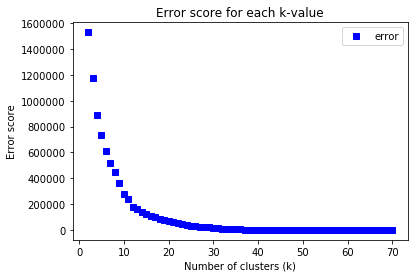

In [73]:
# error
plt.plot(range(2, max_k + 1), error_scores, "bs", label = 'error')
plt.xlabel("Number of clusters (k)")
plt.ylabel('Error score')
plt.legend()
plt.title("Error score for each k-value")
plt.show()

The so-called "elbow" appears to be around 10-13 clusters.

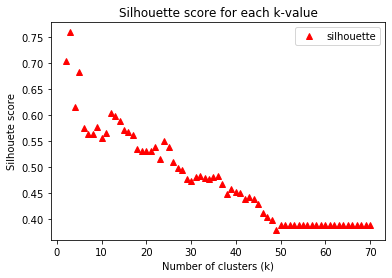

In [74]:
# silhouette
plt.plot(range(2, max_k + 1), sil_scores, "r^", label = 'silhouette')
plt.xlabel("Number of clusters (k)")
plt.ylabel('Silhouete score')
plt.legend()
plt.title("Silhouette score for each k-value")
plt.show()

Is this reasonable?